In [1]:
import pandas as pd

In [7]:
df = pd.read_csv('./data/train.csv', index_col=0)
df.shape

(1023552, 43)

In [8]:
df['stmt_date'] = pd.to_datetime(df['stmt_date'])
df['def_date'] = pd.to_datetime(df['def_date'])

# Calculate 1 year after stmt_date
one_year_after = df['stmt_date'] + pd.DateOffset(years=1)
# Define default if def_date is between stmt_date and one_year_after
df['default'] = ((df['def_date'] >= df['stmt_date']) & (df['def_date'] <= one_year_after)).astype(int)

/var/folders/kj/yvh7dv5569ggqx7tcy8crpp00000gn/T/ipykernel_58963/1789251812.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['def_date'] = pd.to_datetime(df['def_date'])


In [23]:
df.sort_values('stmt_date', inplace=True)

In [12]:
base_rate_all = df['default'].mean()

In [40]:
rate_by_sector = df.groupby('ateco_sector')['default'].mean().reset_index()
rate_by_sector.rename({'default':'preds'},axis=1, inplace=True)

In [26]:
from sklearn import metrics

In [27]:
results = df[['default']]
results['naive_preds'] = base_rate_all

/var/folders/kj/yvh7dv5569ggqx7tcy8crpp00000gn/T/ipykernel_58963/278999573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['naive_preds'] = base_rate_all


ROC AUC 0.5


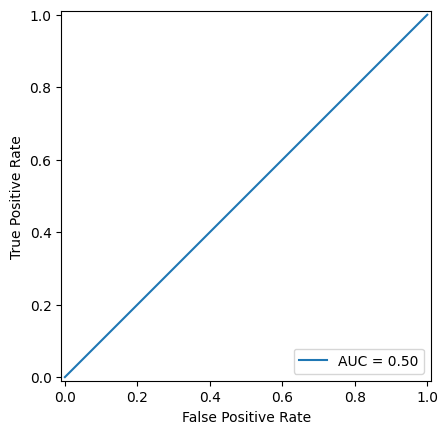

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(results['default'], results['naive_preds'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [34]:
#### by sector naive

In [43]:
sector_res =  df[['id','ateco_sector','default']]
sector_res = sector_res.merge(rate_by_sector, how='left', on='ateco_sector')
sector_res.head()

,id,ateco_sector,default,preds
0,12561010153,42.0,0,0.015186
1,291950632,6.0,0,0.013158
2,2244580425,41.0,0,0.011656
3,9238720156,46.0,0,0.013061
4,2244600355,28.0,0,0.010837


ROC AUC 0.5919196087131395


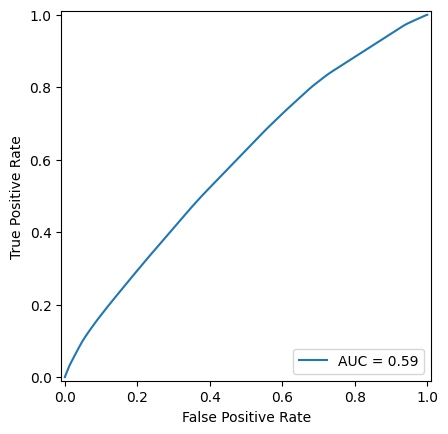

In [44]:
fpr, tpr, thresholds = metrics.roc_curve(sector_res['default'], sector_res['preds'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [ ]:
def walk_forward_harness(df, preprocessor, estimator, predictor, 
                         start, date_col = 'Date', step_size = 1):     
    predictions = []
    # model_list = []
    stats_list = []
    
    proc_all_data , _= preprocessor(df, preproc_params)

    labels = []
    ind = []
    
    for i in range(start,len(proc_all_data), step_size):
        ind.append(i)
        train_data = proc_all_data.iloc[:i]
        test_data = proc_all_data.iloc[[i]]

        algo = smf.logit
    
        trained_model = estimator(train_data, algo, algo_params)
        prediction = predictor(test_data, trained_model)

        labels.append(test_data['positive_return_dummy'].values[0])
        predictions.append(prediction.values[0])
        
        try:
            score = roc_auc_score(y_score=predictions, y_true=labels)
            
        except:
            print('Error scoring')
            score = np.nan
        
        stats_list.append(score)
        model_list.append(trained_model)

        # if i ==5:
        #     break

        progress_bar(i, len(proc_all_data))
        
    predictions = pd.DataFrame([ind,labels,predictions]).T
    predictions.columns = ['index','label','prediction']
    predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)